## 🔹Step 1: Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
)

## 🔹 Step 2: Load and Inspect Data

In [2]:
# Load the dataset
data = pd.read_csv("Heart_Data.csv", na_values="?")

# Display the first 5 rows of the dataset
print("📌 First 5 Rows of Dataset:")
display(data.head())

📌 First 5 Rows of Dataset:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67,1,4,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67,1,4,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37,1,3,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41,0,2,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


## 🔹 Step 3: Data Cleaning

In [3]:
# Drop Unnecessary Columns (Columns with Too Many Missing Values)
data.drop(columns=["slope", "ca", "thal"], inplace=True)

# Identify Feature Types
numerical_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
categorical_cols = ["sex","cp",  "fbs", "restecg", "exang"]

# Convert Target Variable to Binary
data["num"] = data["num"].apply(lambda x: 1 if x > 0 else 0)

# Handling Missing Values
num_imputer = SimpleImputer(strategy="mean")  # Mean for numerical values
cat_imputer = SimpleImputer(strategy="most_frequent")  # Most common category for categorical values

data[numerical_cols] = num_imputer.fit_transform(data[numerical_cols])
data[categorical_cols] = cat_imputer.fit_transform(data[categorical_cols])

# Display the dataset after cleaning
print("✅ Cleaned Dataset Preview:")
display(data.head())

✅ Cleaned Dataset Preview:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,0


## 🔹 Step 4: Descriptive Statistics

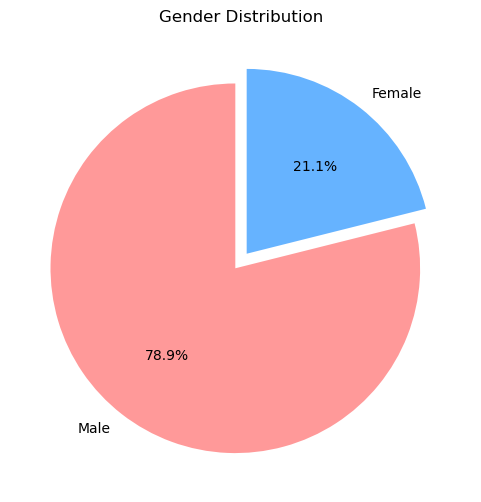

In [4]:
# Male VS Female Count
plt.figure(figsize=(6, 6))
gender_counts = data["sex"].value_counts()
labels = ["Male", "Female"]
colors = ["#ff9999", "#66b3ff"]
plt.pie(gender_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, explode=[0.05, 0.05])
plt.title("Gender Distribution")
plt.show()

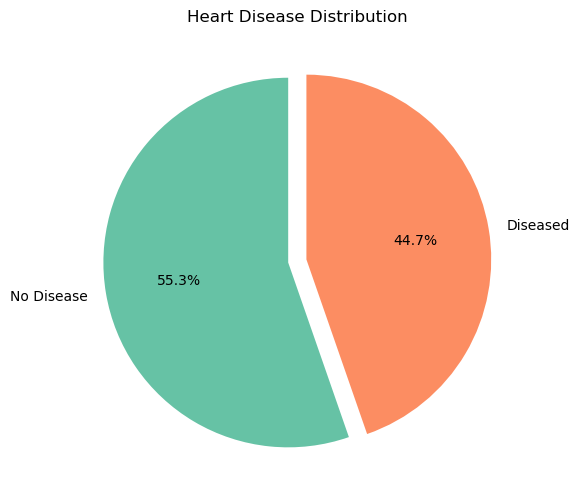

In [5]:
# Heart Disease VS No Disease Count
plt.figure(figsize=(6, 6))
disease_counts = data["num"].value_counts()
labels = ["No Disease", "Diseased"]
colors = ["#66c2a5", "#fc8d62"]
plt.pie(disease_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, explode=[0.05, 0.05])
plt.title("Heart Disease Distribution")
plt.show()

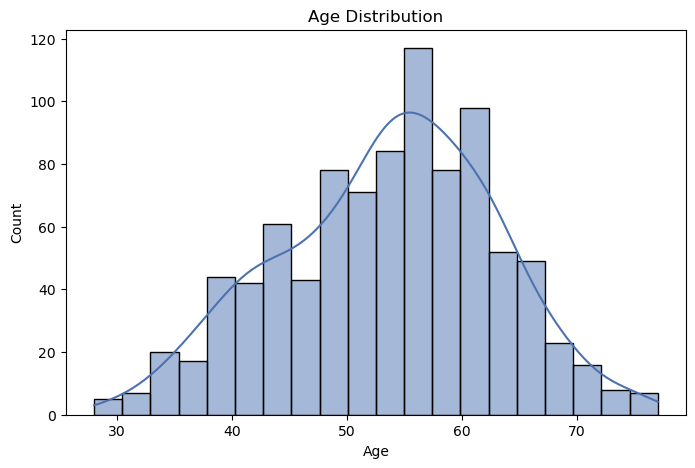

In [6]:
# Age Distribution (Check Normality)
plt.figure(figsize=(8, 5))
sns.histplot(data["age"], bins=20, kde=True, color="#4c72b0")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

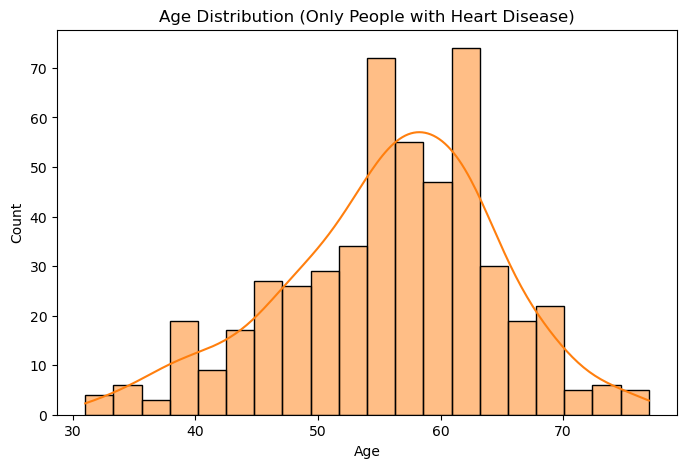

In [7]:
# Filter data for people with heart disease
data_with_disease = data[data["num"] == 1]

# Plot Age Distribution for people with heart disease
plt.figure(figsize=(8, 5))
sns.histplot(data_with_disease["age"], bins=20, kde=True, color="#ff7f0e")
plt.title("Age Distribution (Only People with Heart Disease)")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

## 🔹 Step 5: Feature Engineering

In [8]:
# Separate features and target variable
X = data.drop("num", axis=1)
y = data["num"]

# Define preprocessing for numeric and categorical features
num_transformer = Pipeline(steps=[("scaler", StandardScaler())])
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop="first", handle_unknown='ignore'))])

# Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, numerical_cols),
        ("cat", cat_transformer, categorical_cols),
    ]
)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply transformations
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# save the preprocesssor
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']

## 🔹 Step 6: Model Training

In [9]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
}

# Hyperparameter tuning for KNN
knn_param_grid = {"n_neighbors": [5, 10, 15, 20, 25, 30, 35]}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, scoring="accuracy", cv=5)
knn_grid.fit(X_train, y_train)
best_k = knn_grid.best_params_["n_neighbors"]
models["KNN"] = KNeighborsClassifier(n_neighbors=best_k)

print(f"✅ Best K value for KNN: {best_k}")

✅ Best K value for KNN: 35


## 🔹 Step 7: Models Evaluation and Comparison

In [10]:
# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }
# Convert results to DataFrame (Better for reading)
results_df = pd.DataFrame(results).T
print("\n📌 Model Performance Summary:")
display(results_df)


📌 Model Performance Summary:


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Logistic Regression,0.826087,0.876106,0.846154,0.860870,0.902794
Decision Tree,0.771739,0.831858,0.803419,0.817391,0.759918
Random Forest,0.836957,0.884956,0.854701,0.869565,0.897627
Naive Bayes,0.858696,0.882353,0.897436,0.889831,0.909810
KNN,0.869565,0.918919,0.871795,0.894737,0.914147


## 🔹 Step 8: Feature importance for Random Forest

In [11]:
rf_model_features = models["Random Forest"]
feature_importance = rf_model_features.feature_importances_
feature_names = preprocessor.get_feature_names_out()
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
print("\n📌 Feature Importance:")
print(importance_df.sort_values("Importance", ascending=False))


📌 Feature Importance:
             Feature  Importance
2          num__chol    0.145704
3       num__thalach    0.136299
0           num__age    0.127218
4       num__oldpeak    0.117572
1      num__trestbps    0.103741
8        cat__cp_4.0    0.102695
12    cat__exang_1.0    0.083800
6        cat__cp_2.0    0.059428
5       cat__sex_1.0    0.048612
7        cat__cp_3.0    0.023505
10  cat__restecg_1.0    0.019201
11  cat__restecg_2.0    0.016167
9       cat__fbs_1.0    0.016058


## 🔹 Step 9: Best Model

In [12]:
# Select the best model based on Accuracy
best_model_name = max(results, key=lambda x: results[x]["Accuracy"])
print(f"\n✅ The best model is {best_model_name}")


✅ The best model is KNN


## 🔹 Step 10: Save all of the models

In [13]:
# Save all models with cleaner loop
for name, model in models.items():
    filename = f"{name.lower().replace(' ', '_')}.pkl"
    joblib.dump(model, filename)
    print(f"✅ {filename}")

✅ logistic_regression.pkl
✅ decision_tree.pkl
✅ random_forest.pkl
✅ naive_bayes.pkl
✅ knn.pkl
